# Neuromodulated ratio estimation

In [1]:
import torch
import hypothesis
import matplotlib.pyplot as plt
import numpy as np

from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from hypothesis.visualization.util import make_square

## Forward model and prior

In [2]:
prior = Uniform(-10, 10)

def simulate(inputs):
    return Normal(inputs, 1).sample().view(-1, 1).detach()

## Hyperparameters

In [3]:
batch_size = 256
dataset_size = 1000000
epochs = 10
layers = (32, 32, 32)

## Neuromodulated approach

### Controller allocator

In [4]:
def allocate_controller(hidden=32):
    controller = torch.nn.Sequential(
        torch.nn.Linear(1, hidden),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(hidden, hidden),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(hidden, 1))
    
    return controller

### Training

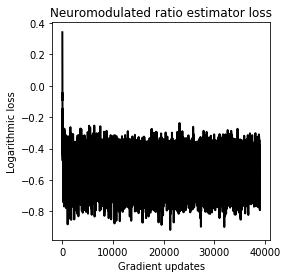

In [5]:
from hypothesis.nn.amortized_ratio_estimation import LikelihoodToEvidenceCriterion as Criterion
from hypothesis.nn.amortized_ratio_estimation import LikelihoodToEvidenceRatioEstimatorNeuromodulatedMLP as NeuromodulatedRatioEstimator
from hypothesis.util.data import SimulatorDataset
from torch.utils.data import DataLoader

dataset = SimulatorDataset(simulate, prior, size=dataset_size)
neuromodulated_ratio_estimator = NeuromodulatedRatioEstimator(shape_outputs=(1,), controller_allocator=allocate_controller)
neuromodulated_ratio_estimator = neuromodulated_ratio_estimator.to(hypothesis.accelerator)
neuromodulated_ratio_estimator = neuromodulated_ratio_estimator.train()
criterion = Criterion(neuromodulated_ratio_estimator, batch_size).to(hypothesis.accelerator)
optimizer = torch.optim.Adam(neuromodulated_ratio_estimator.parameters(), amsgrad=True)

losses = []
for epoch in range(epochs):
    data_loader = DataLoader(dataset, num_workers=4, shuffle=True, batch_size=batch_size, drop_last=True)
    for inputs, outputs in data_loader:
        inputs = inputs.to(hypothesis.accelerator).view(-1, 1)
        outputs = outputs.to(hypothesis.accelerator).view(-1, 1)
        loss = criterion(inputs=inputs, outputs=outputs)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

neuromodulated_ratio_estimator = neuromodulated_ratio_estimator.cpu()
neuromodulated_ratio_estimator.eval()

losses = np.log(np.array(losses))
plt.title("Neuromodulated ratio estimator loss")
plt.xlabel("Gradient updates")
plt.ylabel("Logarithmic loss")
plt.plot(range(len(losses)), losses, lw=2, color="black")
make_square(plt.gca())
plt.show()

## Conventional approach

### Training

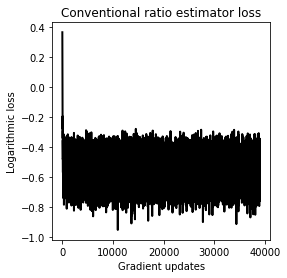

In [6]:
from hypothesis.nn.amortized_ratio_estimation import LikelihoodToEvidenceRatioEstimatorMLP as ConventionalRatioEstimator

dataset = SimulatorDataset(simulate, prior, size=dataset_size)
conventional_ratio_estimator = ConventionalRatioEstimator(shape_inputs=(1,), shape_outputs=(1,), layers=layers)
conventional_ratio_estimator = conventional_ratio_estimator.to(hypothesis.accelerator)
conventional_ratio_estimator.train()
criterion = Criterion(conventional_ratio_estimator, batch_size).to(hypothesis.accelerator)
optimizer = torch.optim.Adam(conventional_ratio_estimator.parameters(), amsgrad=True)

losses = []
for epoch in range(epochs):
    data_loader = DataLoader(dataset, num_workers=4, shuffle=True, batch_size=batch_size, drop_last=True)
    for inputs, outputs in data_loader:
        inputs = inputs.to(hypothesis.accelerator).view(-1, 1)
        outputs = outputs.to(hypothesis.accelerator).view(-1, 1)
        loss = criterion(inputs=inputs, outputs=outputs)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

conventional_ratio_estimator = conventional_ratio_estimator.cpu()
conventional_ratio_estimator.eval()

losses = np.log(np.array(losses))
plt.title("Conventional ratio estimator loss")
plt.xlabel("Gradient updates")
plt.ylabel("Logarithmic loss")
plt.plot(range(len(losses)), losses, lw=2, color="black")
make_square(plt.gca())
plt.show()

## Inference

In [7]:
truth = float(0)
observation = simulate(torch.tensor(truth)).view(-1, 1)

resolution = 1000
observations = observation.repeat(resolution, 1).view(-1, 1)
thetas = torch.linspace(-10, 10, resolution).view(-1, 1)

### Neuromdulated ratio estimator

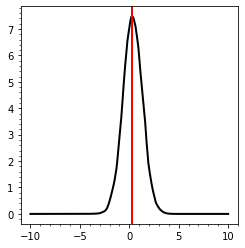

In [8]:
log_ratios = neuromodulated_ratio_estimator.log_ratio(thetas, observations)

plt.plot(thetas.numpy(), log_ratios.exp().detach().numpy(), lw=2, color="black")
plt.axvline(observation.numpy(), color="red", lw=2)
plt.minorticks_on()
make_square(plt.gca())
plt.show()

### Conventional ratio estimator

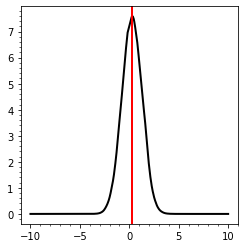

In [9]:
log_ratios = conventional_ratio_estimator.log_ratio(thetas, observations)

plt.plot(thetas.numpy(), log_ratios.exp().detach().numpy(), lw=2, color="black")
plt.axvline(observation.numpy(), color="red", lw=2)
plt.minorticks_on()
make_square(plt.gca())
plt.show()